In [1]:
%%capture
!pip install skyfield pytz astral gdown

In [2]:
LAT, LON = (20.99365, 105.86950277777778)
ALTITUDE = 15.4
HORIZON = 5
BEARINGS = (58, 90)
TIMEZONE = 'Asia/Ho_Chi_Minh'

In [3]:
from skyfield.api import load, Topos

EPH = load('de421.bsp')

location = Topos(
    latitude_degrees=LAT,
    longitude_degrees=LON,
    elevation_m=ALTITUDE,
)
observer = EPH['earth'] + location
observer

<VectorSum of 3 vectors:
 'de421.bsp' segment 0 SOLAR SYSTEM BARYCENTER -> 3 EARTH BARYCENTER
 'de421.bsp' segment 3 EARTH BARYCENTER -> 399 EARTH
 Geodetic 399 EARTH -> IERS2010 latitude +20.9936 N longitude 105.8695 E elevation 15.4 m>

In [4]:
from datetime import datetime, timezone
from astral import LocationInfo
from astral.sun import sun

def get_sunset_time(dt, latitude, longitude):
    location = LocationInfo(latitude=latitude, longitude=longitude)
    s = sun(location.observer, date=dt.date())
    return s['dusk']

dt = datetime.now(timezone.utc)
sunset_dt = get_sunset_time(dt, LAT, LON)
sunset_dt

datetime.datetime(2024, 11, 19, 10, 38, 6, 898390, tzinfo=datetime.timezone.utc)

In [5]:
ts = load.timescale()
sunset_t = ts.from_datetime(sunset_dt)
sunset_t

<Time tt=2460633.943936139>

In [6]:
def get_position(planet_name, observer, time):
    planet = EPH[planet_name]
    astrometric = observer.at(time).observe(planet)
    return astrometric.apparent().altaz()

position = get_position('mars', observer, sunset_t)
position

(<Angle -44deg 34' 14.5">, <Angle 22deg 49' 39.5">, <Distance 0.884979 au>)

In [7]:
def is_within_fov(az, angle1, angle2):
    if angle1 > angle2:
        angle1, angle2 = angle2, angle1

    if angle1 <= az.degrees <= angle2:
        return True

    if angle2 - angle1 > 180:
        return angle2 <= az.degrees <= angle1 + 360 or 0 <= az.degrees <= angle2

def is_visible(position, horizon, bearings):
  alt, az, _ = position

  if alt.degrees < horizon:
    return (False, 'Below horizon')

  within_fov = is_within_fov(az, bearings[0], bearings[1])
  if not within_fov:
    return (False, 'Outside field of view')

  return (True, None)

is_visible(position, HORIZON, BEARINGS)

(False, 'Below horizon')

In [8]:
import pprint
import pytz
from datetime import timedelta

# Stop condition to make sure we do not make too many predictions
def is_out_of_range(t):
    today = datetime.now(pytz.utc)
    one_day_later = today + timedelta(days=1)
    current_dt = t.astimezone(LOCAL_TIMEZONE)
    return current_dt > one_day_later

# This tell us when the sky is dark enough to see planets
def is_night(dt, latitude, longitude):
    location = LocationInfo(latitude=latitude, longitude=longitude)
    s = sun(location.observer, date=dt.date())
    return  dt <= s['dawn'] and dt >= s['dusk']

# Define planets with the key to lookup ephemeris
PLANETS = {
    'Mercury': 'mercury',
    'Venus': 'venus',
    'Mars': 'mars',
    'Jupiter': 'jupiter barycenter',
    'Saturn': 'saturn barycenter',
    'Uranus': 'uranus barycenter',
    'Neptune': 'neptune barycenter',
}

sky_objects = {}
LOCAL_TIMEZONE = pytz.timezone(TIMEZONE)

for planet_name, planet_lookup_name in PLANETS.items():
  sky_objects[planet_name] = []
  dt = datetime.now(timezone.utc)

  night_dt = get_sunset_time(dt, LAT, LON)
  t = ts.from_datetime(night_dt)

  while not is_out_of_range(t):
    dt = t.utc_datetime()

    if not is_night(dt, LAT, LON):
        night_dt = get_sunset_time(dt, LAT, LON)

        t = ts.from_datetime(night_dt)
        t += timedelta(days=1)

    position = get_position(planet_lookup_name, observer, t)

    is_planet_visible, _ = is_visible(position, HORIZON, BEARINGS)
    if is_planet_visible:
        alt, az, _ = position

        local_dt = t.astimezone(LOCAL_TIMEZONE)
        event_time = local_dt.strftime('%Y-%m-%dT%H:%M:%S')

        sky_objects[planet_name].append({
            'event_time': event_time,
            'azimuth': az.degrees,
            'altitude': alt.degrees,
        })

    t += timedelta(hours=1)

pp = pprint.PrettyPrinter(indent=4)
pp.pprint(sky_objects)

{   'Jupiter': [   {   'altitude': 13.681995131743427,
                       'azimuth': 71.09062577538539,
                       'event_time': '2024-11-19T19:38:06'},
                   {   'altitude': 27.12010319615951,
                       'azimuth': 74.9769903060591,
                       'event_time': '2024-11-19T20:38:06'},
                   {   'altitude': 40.785489158658685,
                       'azimuth': 78.19015959500315,
                       'event_time': '2024-11-19T21:38:06'},
                   {   'altitude': 54.598599860070784,
                       'azimuth': 80.77820587192595,
                       'event_time': '2024-11-19T22:38:06'},
                   {   'altitude': 68.4989035210327,
                       'azimuth': 82.38219260096993,
                       'event_time': '2024-11-19T23:38:06'},
                   {   'altitude': 82.39891432209217,
                       'azimuth': 78.99561311299922,
                       'event_time': '2024-11-20T00:

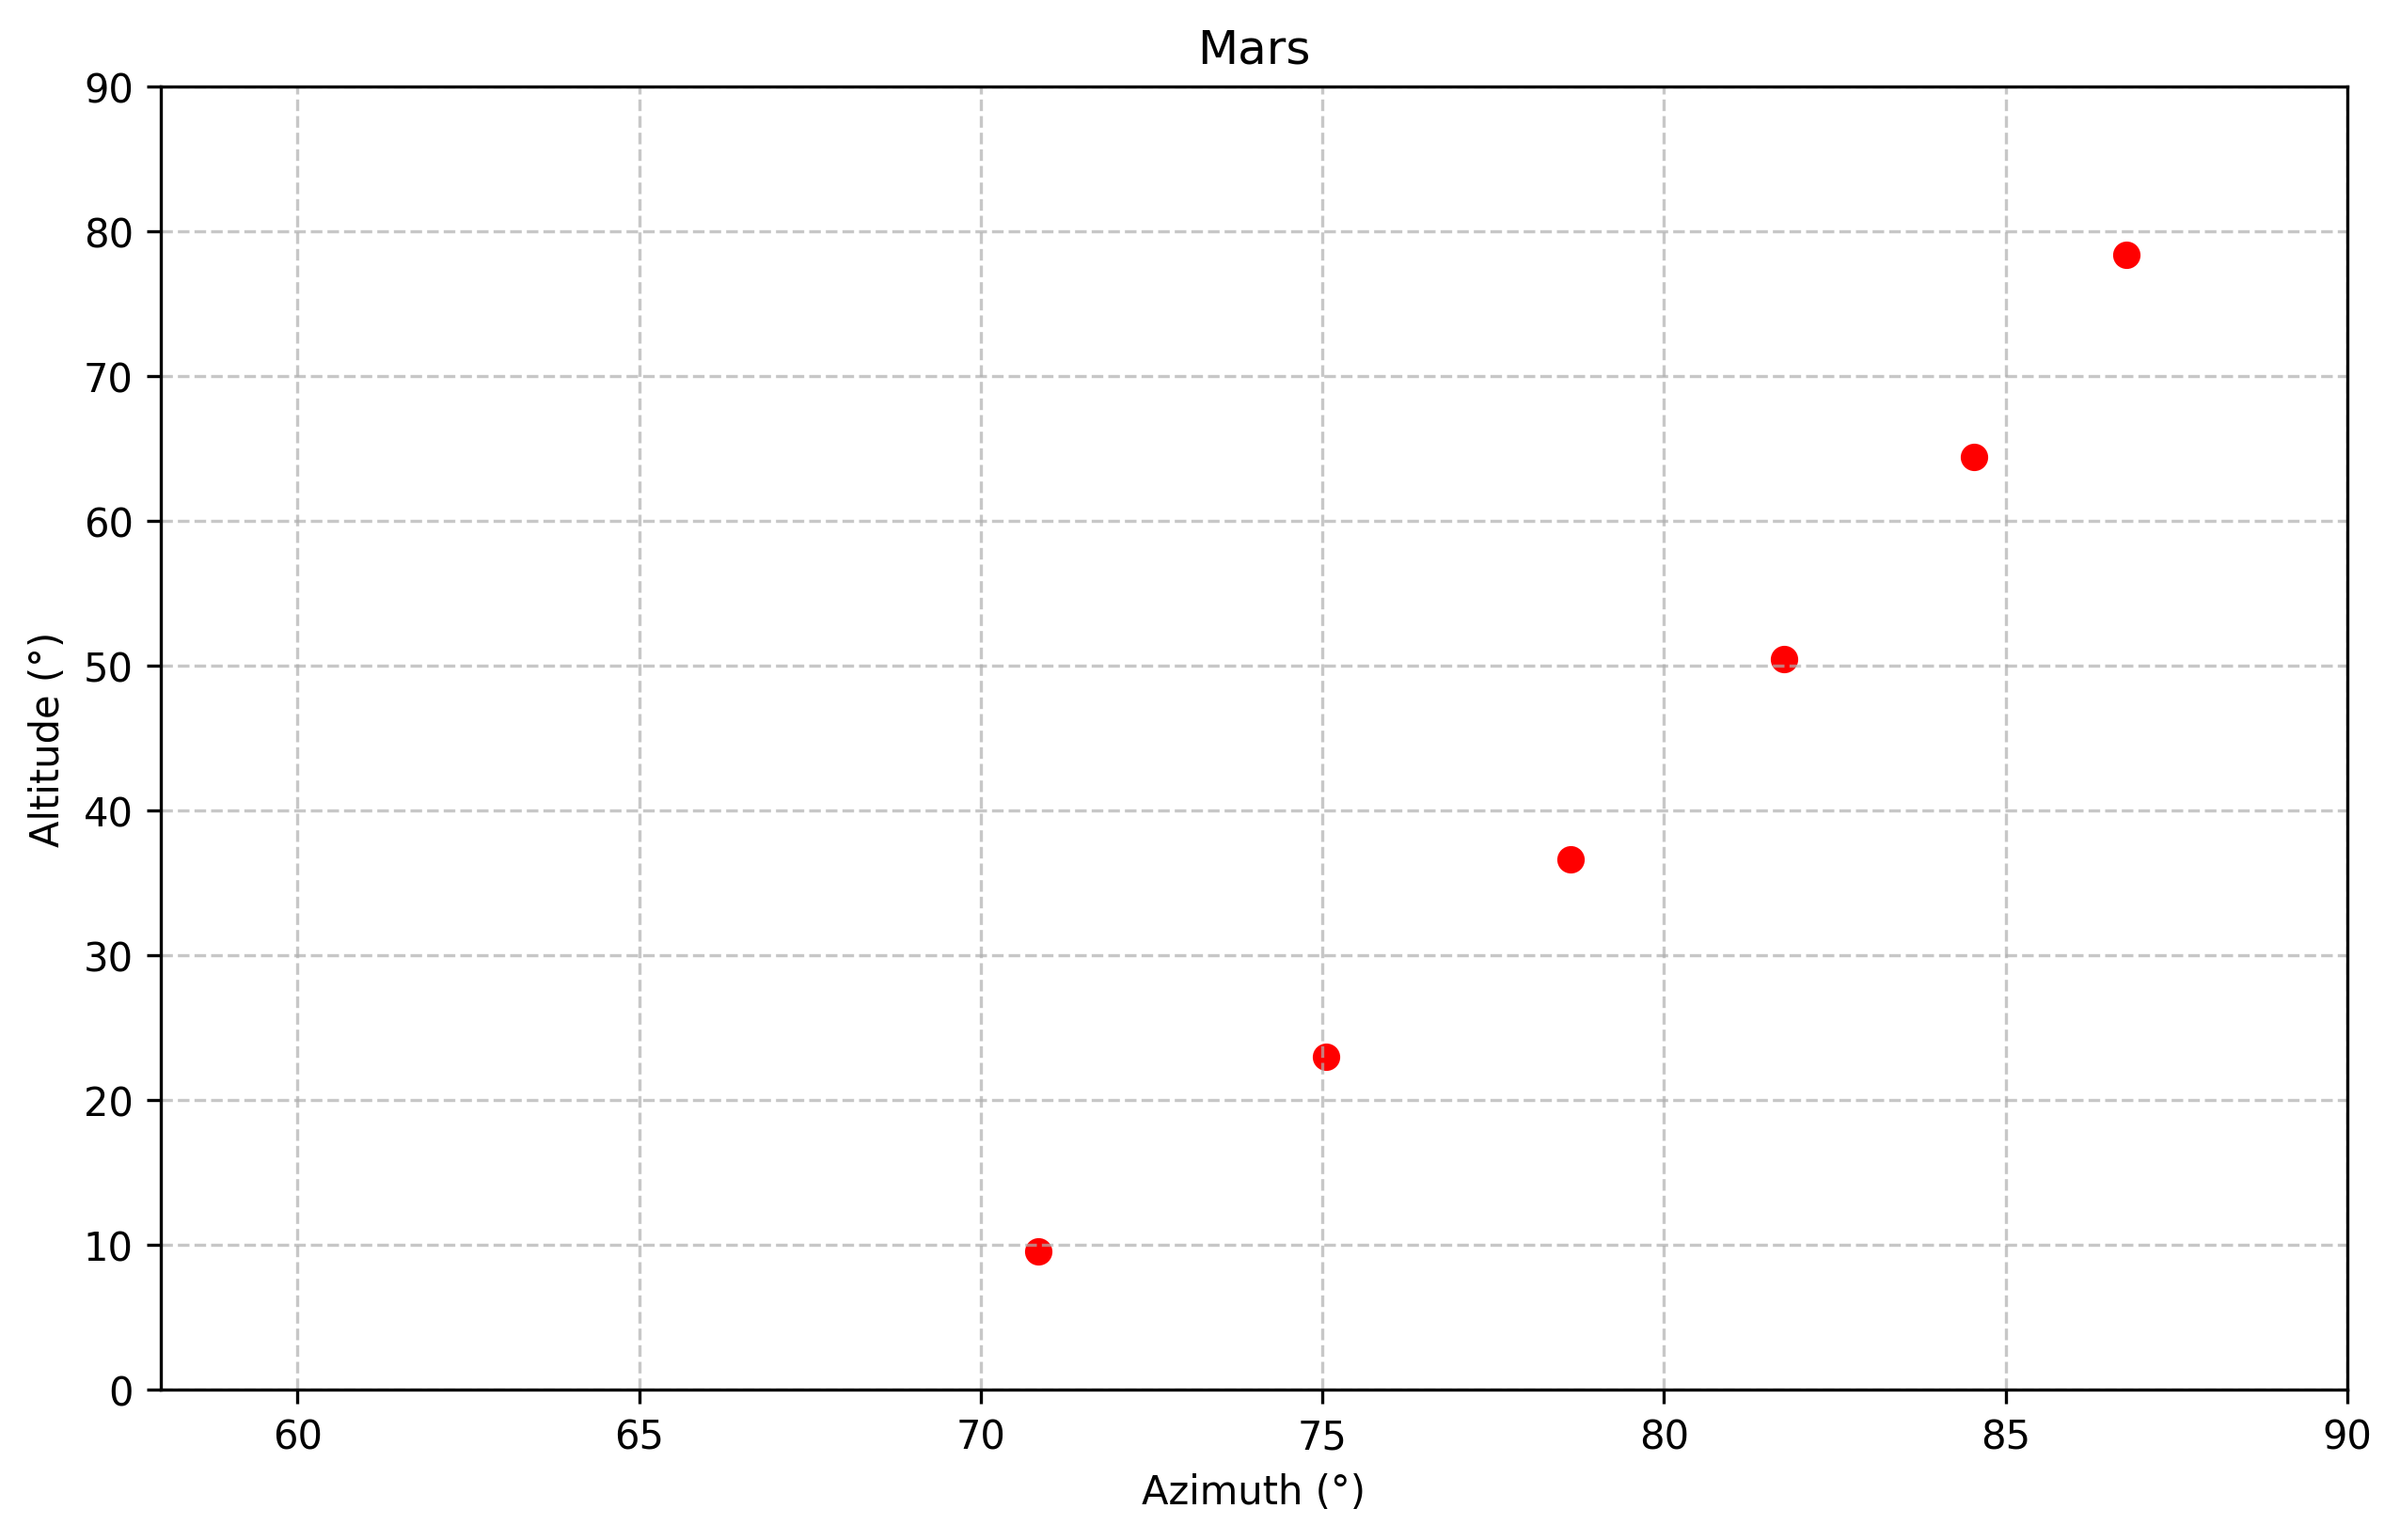

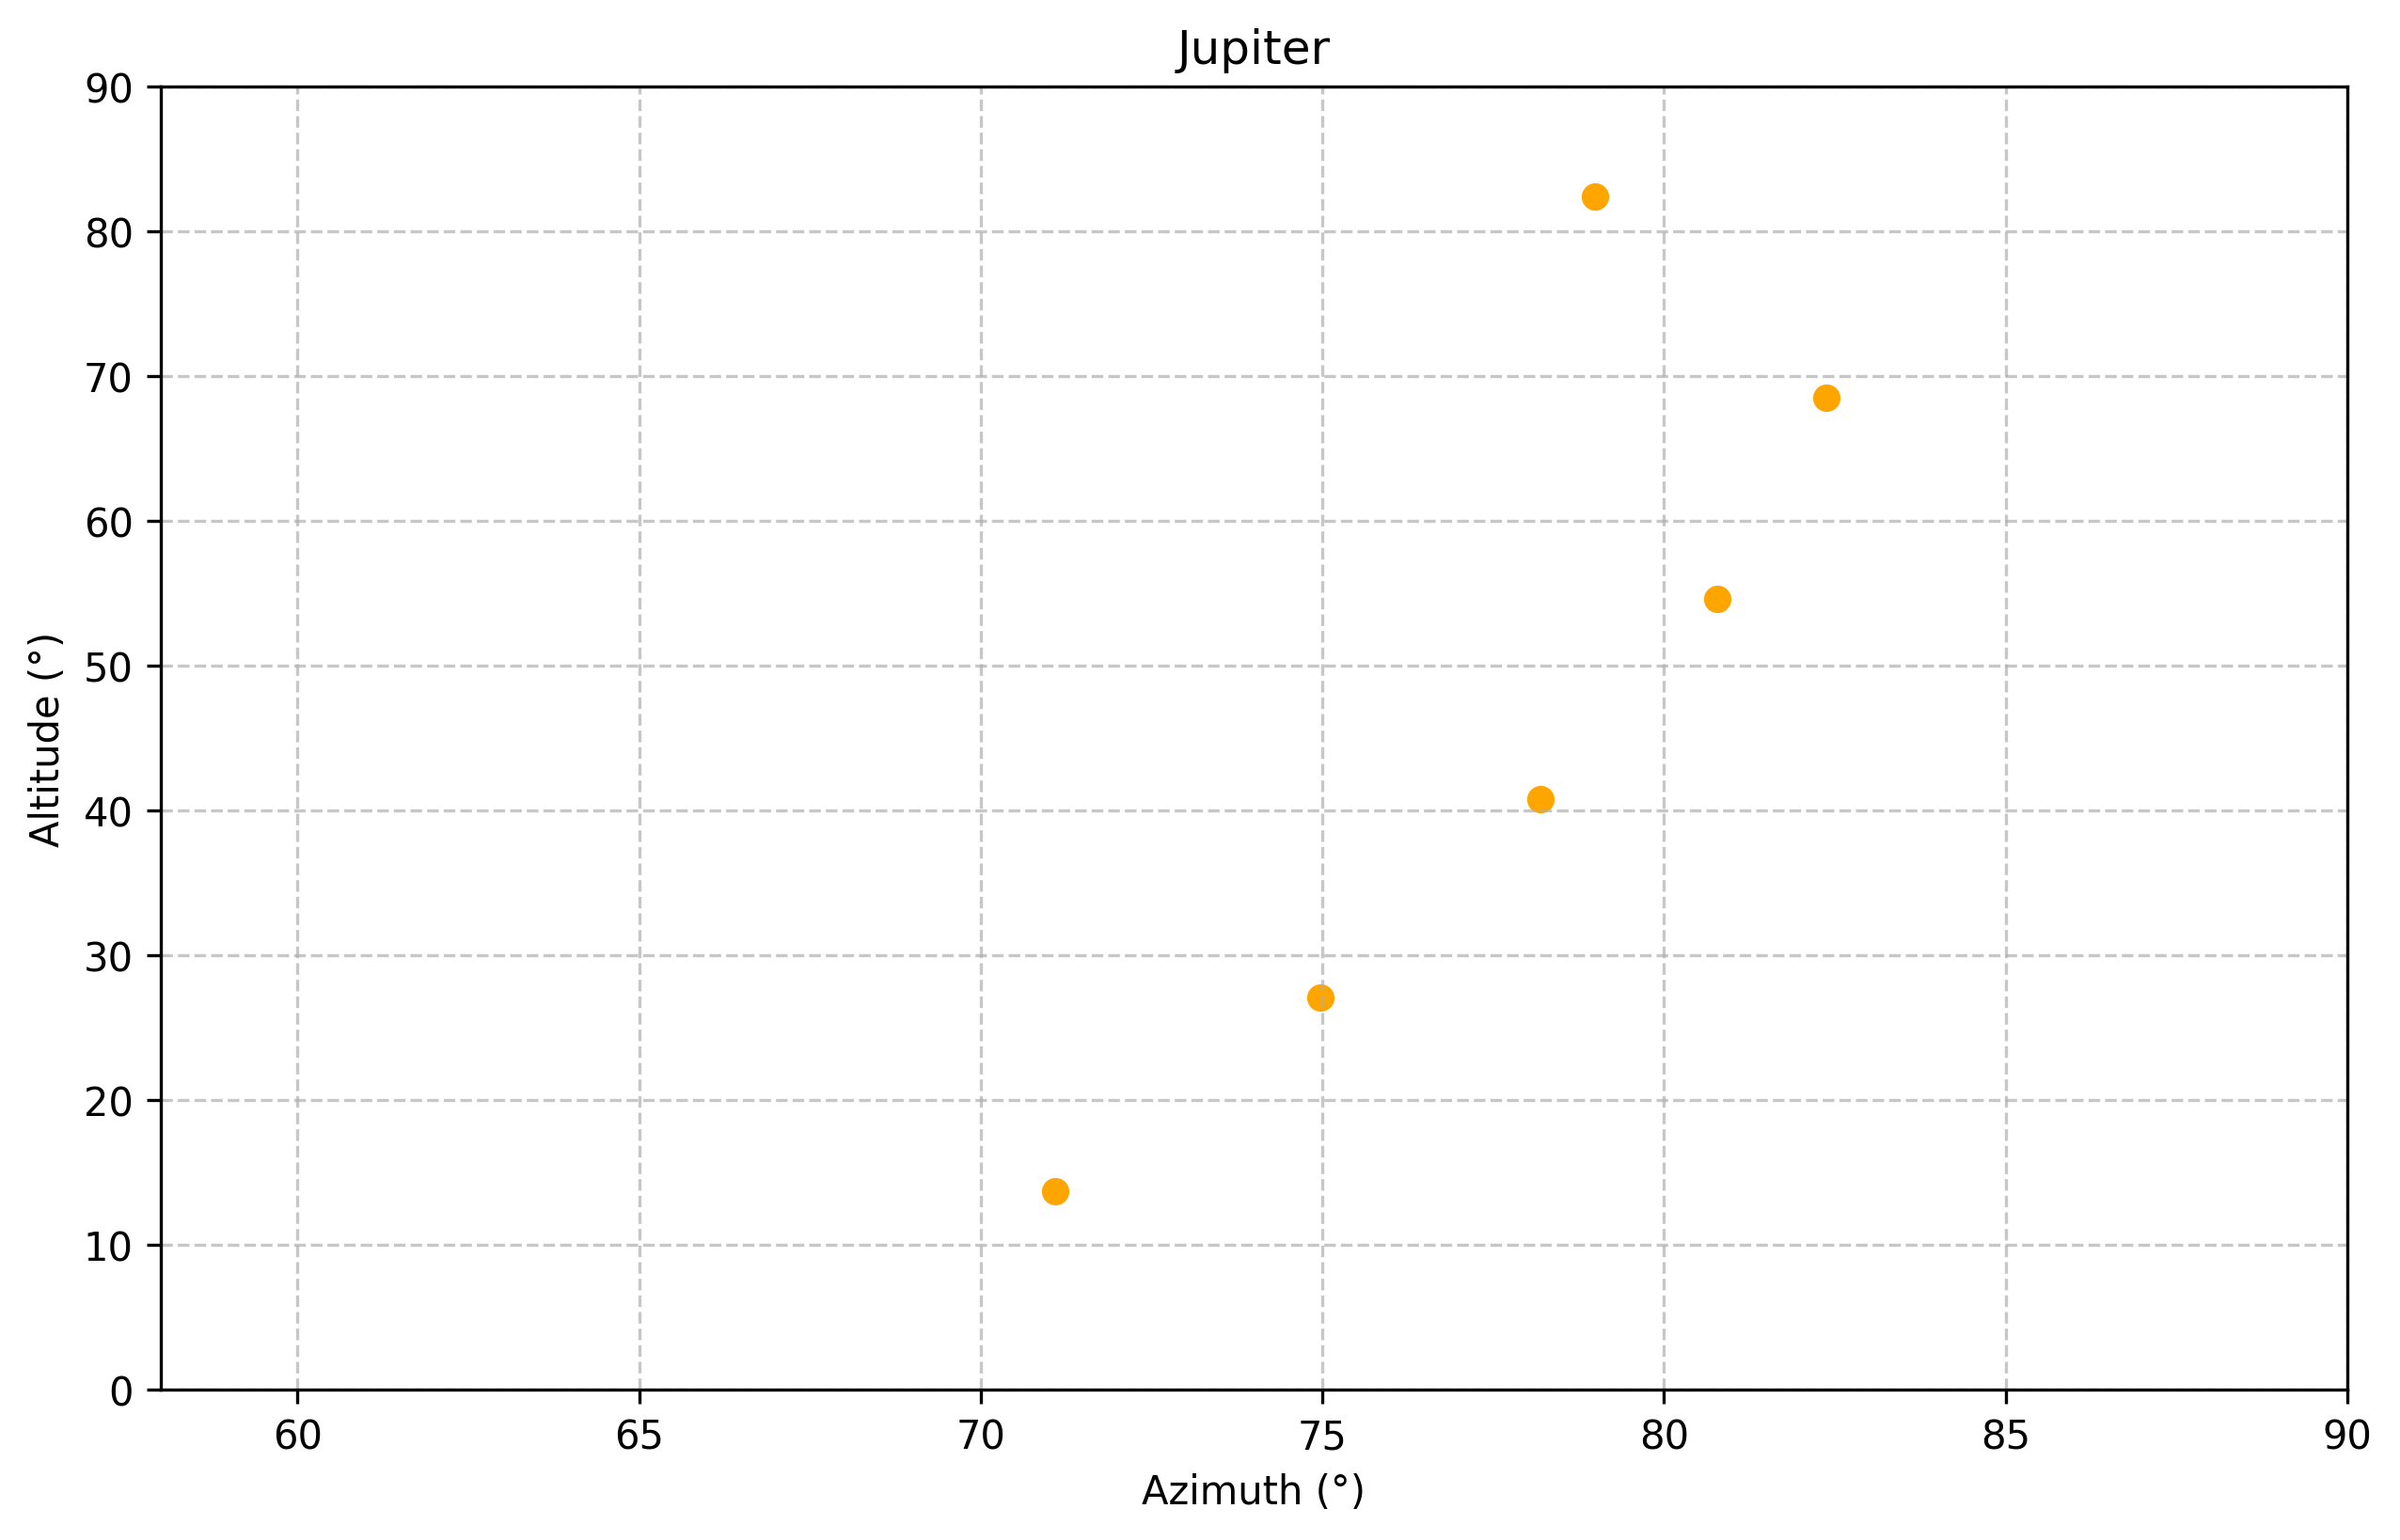

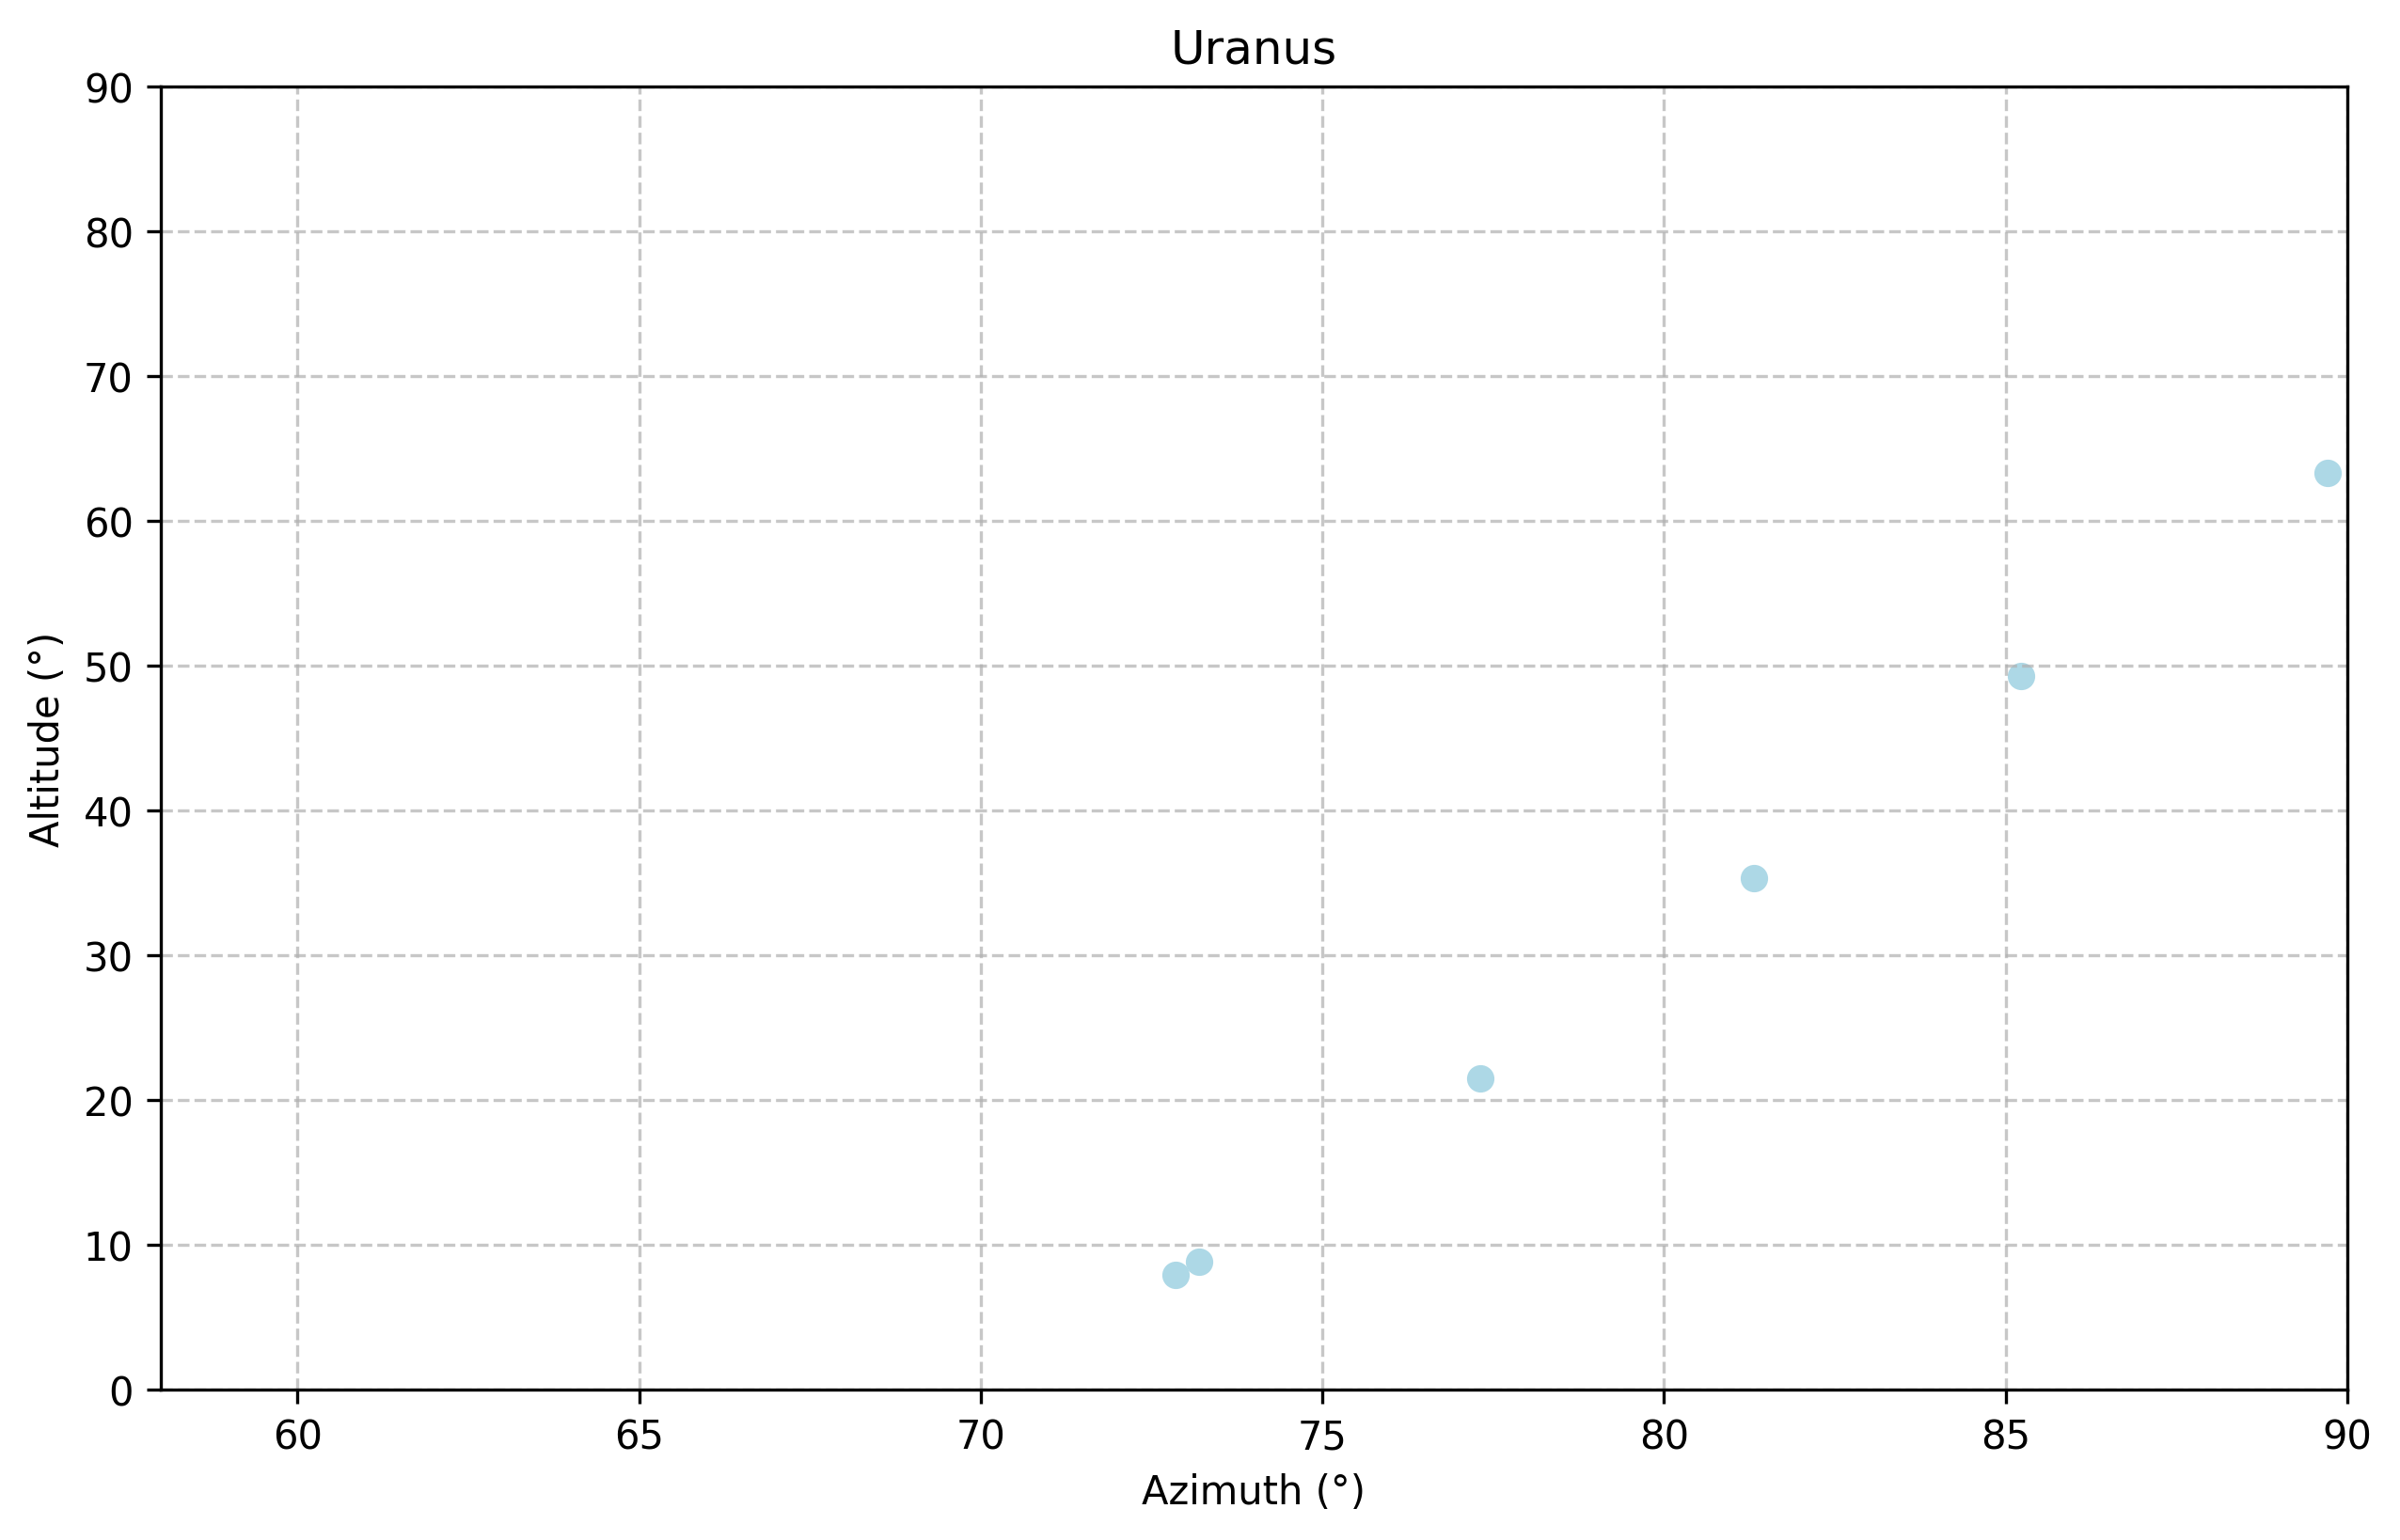

In [9]:
import matplotlib.pyplot as plt

PLANET_COLORS = {
    'Mercury': 'gray',
    'Venus': 'yellow',
    'Earth': 'blue',
    'Mars': 'red',
    'Jupiter': 'orange',
    'Saturn': 'gold',
    'Uranus': 'lightblue',
    'Neptune': 'darkblue',
}

def plot_position(planet_name, observations):
  azimuths = [obs['azimuth'] for obs in observations]
  altitudes = [obs['altitude'] for obs in observations]

  plt.style.use('default')
  plt.figure(figsize=(10, 6), dpi=300)
  plt.scatter(azimuths, altitudes, color=PLANET_COLORS[planet_name])

  plt.title(planet_name.capitalize())
  plt.xlabel('Azimuth (°)')
  plt.ylabel('Altitude (°)')

  plt.xlim(BEARINGS[0], BEARINGS[1])
  plt.ylim(0, 90)

  plt.grid(True, linestyle='--', alpha=0.7)
  plt.show()

for planet_name, observations in sky_objects.items():
  if not observations:
    continue

  plot_position(planet_name, observations)

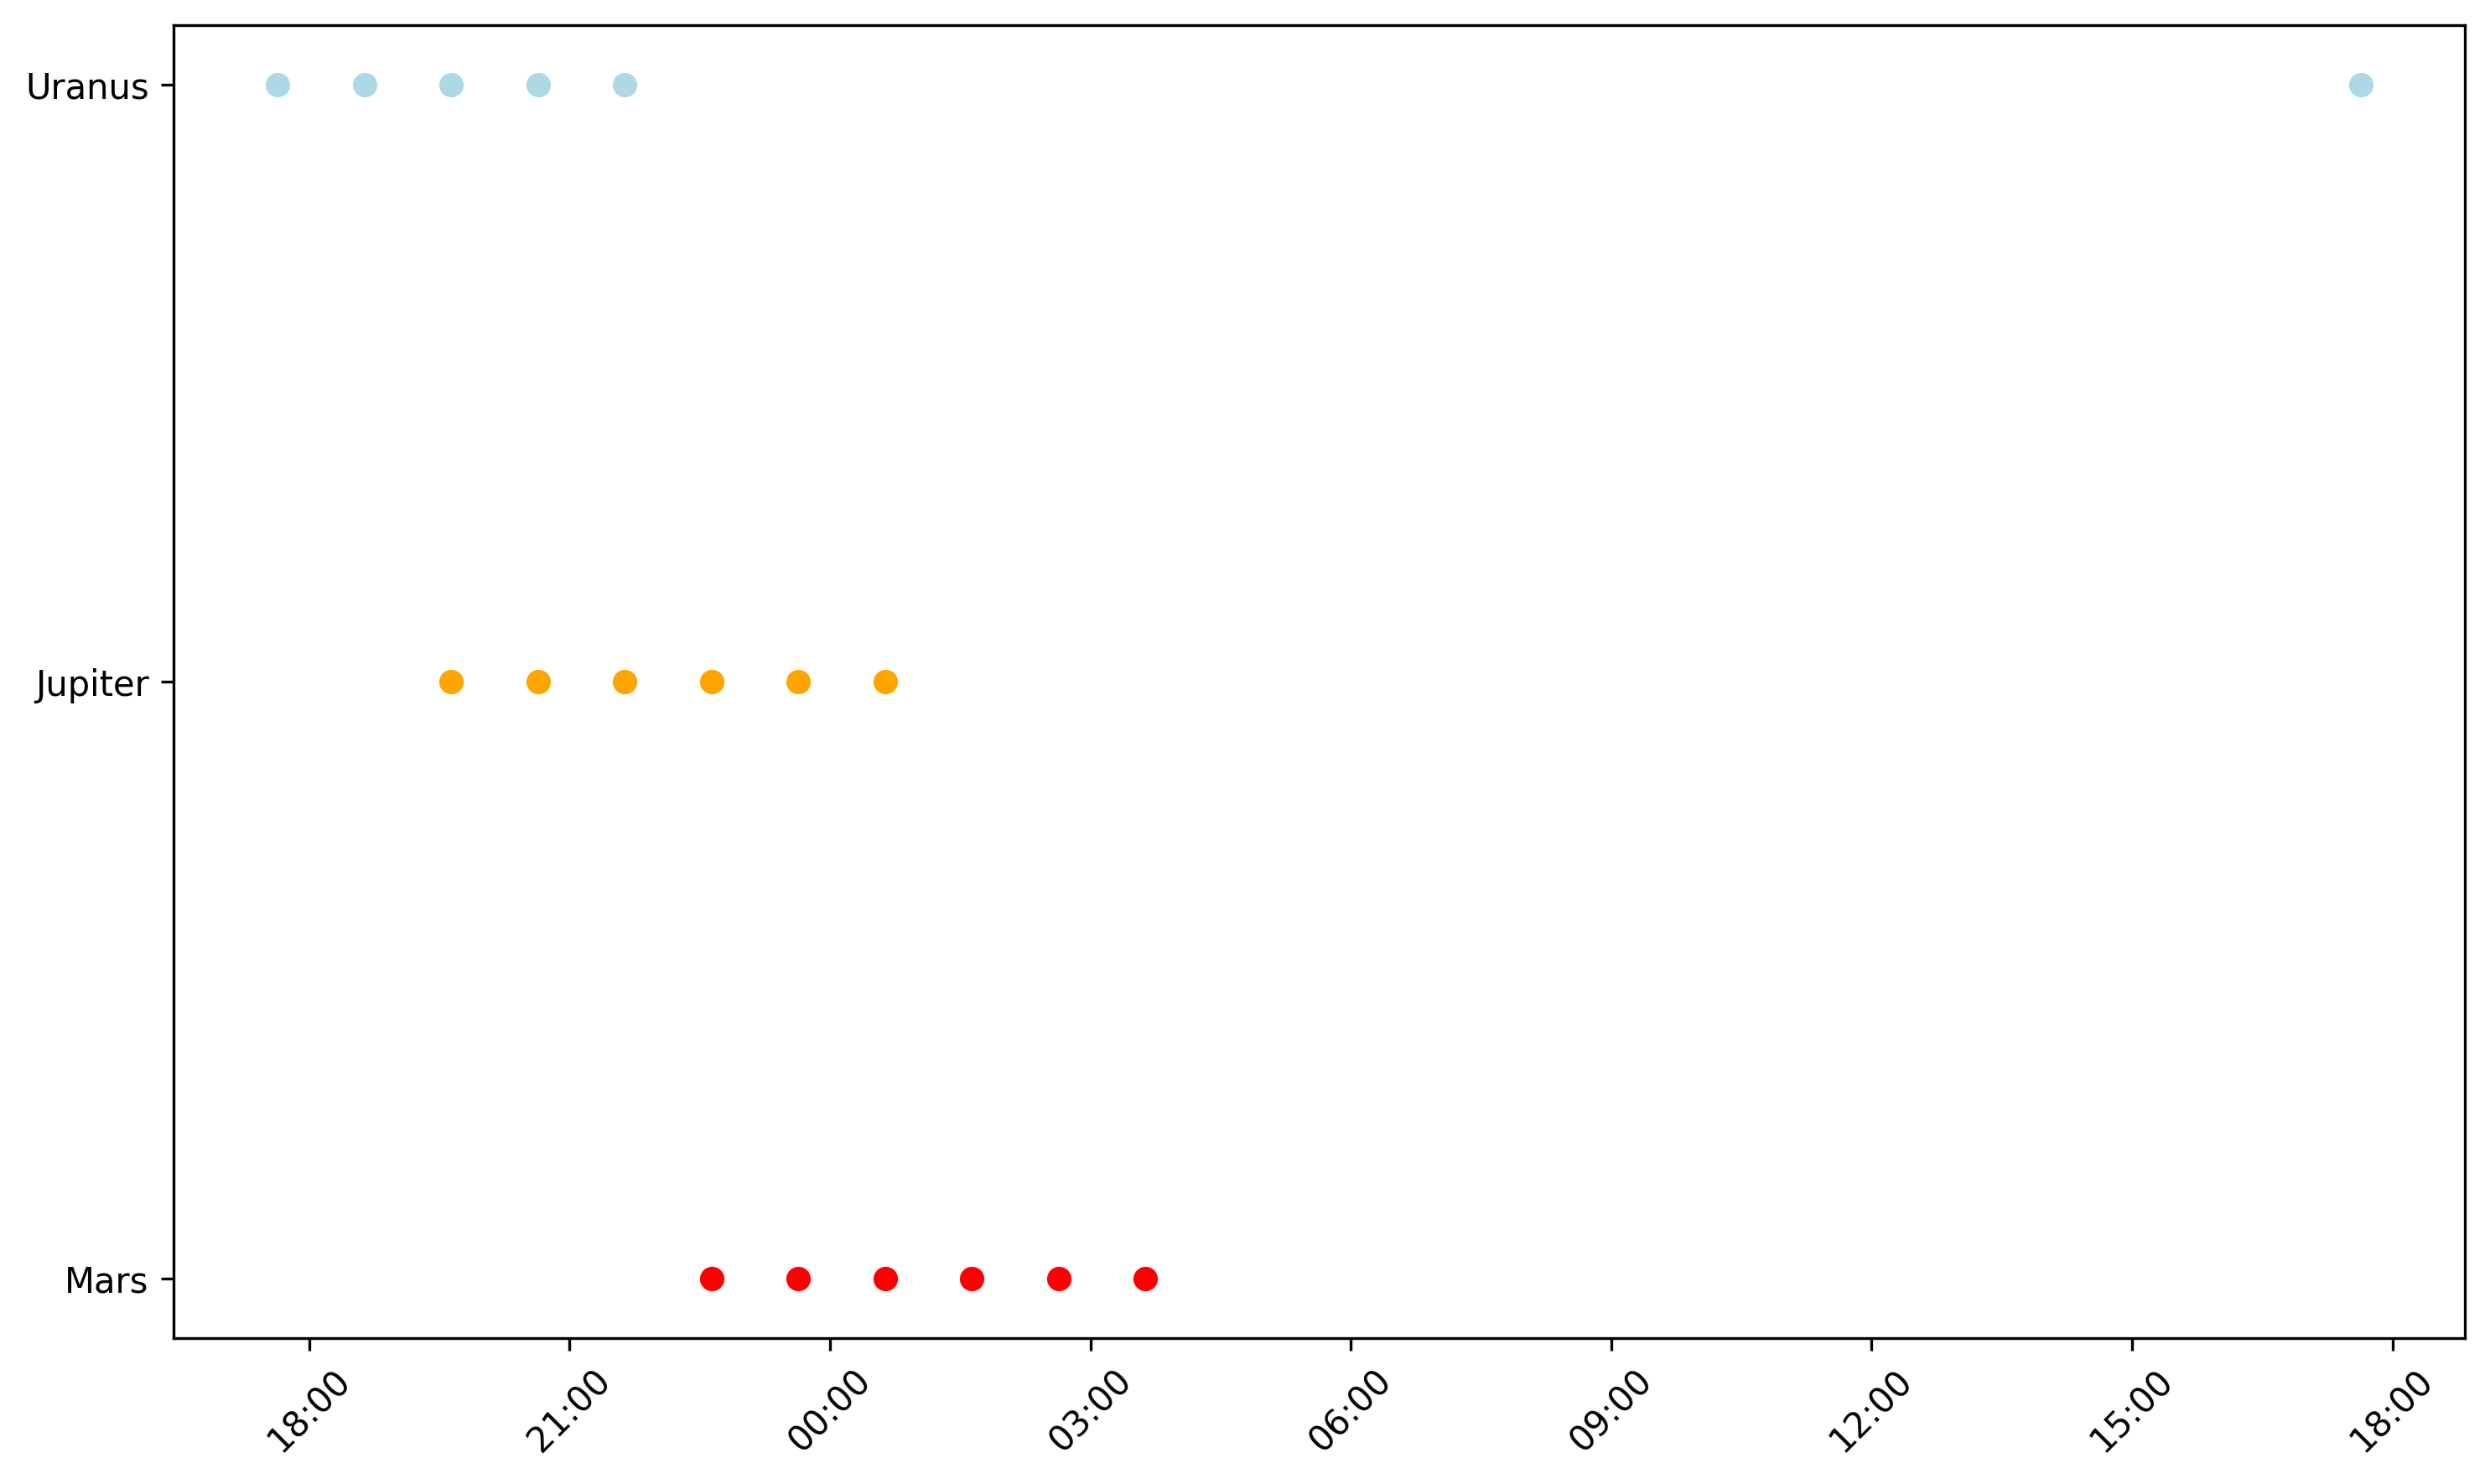

In [10]:
import matplotlib.dates as mdates

def plot_timeline(data):
  plt.style.use('default')
  fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

  y_positions = {planet: i for i, planet in enumerate([p for p, e in data.items() if e])}

  for planet, events in data.items():
      if not events:
        continue

      times = [datetime.fromisoformat(event['event_time']) for event in events]
      ax.plot(times, [y_positions[planet]] * len(times), 'o', c=PLANET_COLORS[planet])

  ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
  plt.xticks(rotation=45)

  ax.set_yticks(list(y_positions.values()))
  ax.set_yticklabels(list(y_positions.keys()))

  plt.tight_layout()
  plt.show()

plot_timeline(sky_objects)

In [11]:
%%capture

import gdown

STAR_NAMES = 'star_names.csv'
STAR_NAMES_URL = 'https://drive.google.com/file/d/1LtZqSzPvtkDZNswYLk999i7hWgG5HhrI/view?usp=sharing'

gdown.download(STAR_NAMES_URL, STAR_NAMES, quiet=True, fuzzy=True)

In [12]:
import pandas as pd
from skyfield.data import hipparcos

hipparcos_df = hipparcos.load_dataframe(load.open(hipparcos.URL))
star_df = pd.read_csv('star_names.csv')
df = pd.merge(hipparcos_df, star_df, left_on='hip', right_on='hip_id', how='inner')

df.shape

(96, 10)

In [17]:
df = df[df['magnitude'] <= 1.0]

df.shape

(16, 10)

In [18]:
from skyfield.api import Star

stars = {}

ts = load.timescale()
for index, star_data in df.iterrows():
  star_name = star_data['name']

  stars[star_name] = []
  dt = datetime.now(timezone.utc)

  night_dt = get_sunset_time(dt, LAT, LON)
  t = ts.from_datetime(night_dt)

  while not is_out_of_range(t):
    dt = t.utc_datetime()

    if not is_night(dt, LAT, LON):
        night_dt = get_sunset_time(dt, LAT, LON)

        t = ts.from_datetime(night_dt)
        t += timedelta(days=1)

    star = Star.from_dataframe(star_data)
    astrometric = observer.at(t).observe(star)
    position = astrometric.apparent().altaz()

    is_star_visible, _ = is_visible(position, HORIZON, BEARINGS)
    if is_star_visible:
        alt, az, _ = position

        local_dt = t.astimezone(LOCAL_TIMEZONE)
        event_time = local_dt.strftime('%Y-%m-%dT%H:%M:%S')

        stars[star_name].append({
            'event_time': event_time,
            'azimuth': az.degrees,
            'altitude': alt.degrees,
            'magnitude': star_data['magnitude'],
        })

    t += timedelta(hours=1)

pp = pprint.PrettyPrinter(indent=4)
pp.pprint(stars)

{   'Achernar': [],
    'Acrux': [],
    'Agena': [],
    'Aldebaran': [   {   'altitude': 5.905535311125896,
                         'azimuth': 74.5007286739326,
                         'event_time': '2024-11-19T18:38:06',
                         'magnitude': 0.87},
                     {   'altitude': 19.578418030175207,
                         'azimuth': 79.1904960157016,
                         'event_time': '2024-11-19T19:38:06',
                         'magnitude': 0.87},
                     {   'altitude': 33.45905374248031,
                         'azimuth': 83.54996332222981,
                         'event_time': '2024-11-19T20:38:06',
                         'magnitude': 0.87},
                     {   'altitude': 47.45989809775277,
                         'azimuth': 88.08856824279069,
                         'event_time': '2024-11-19T21:38:06',
                         'magnitude': 0.87}],
    'Altair': [],
    'Arcturus': [   {   'altitude': 11.724348629463824,


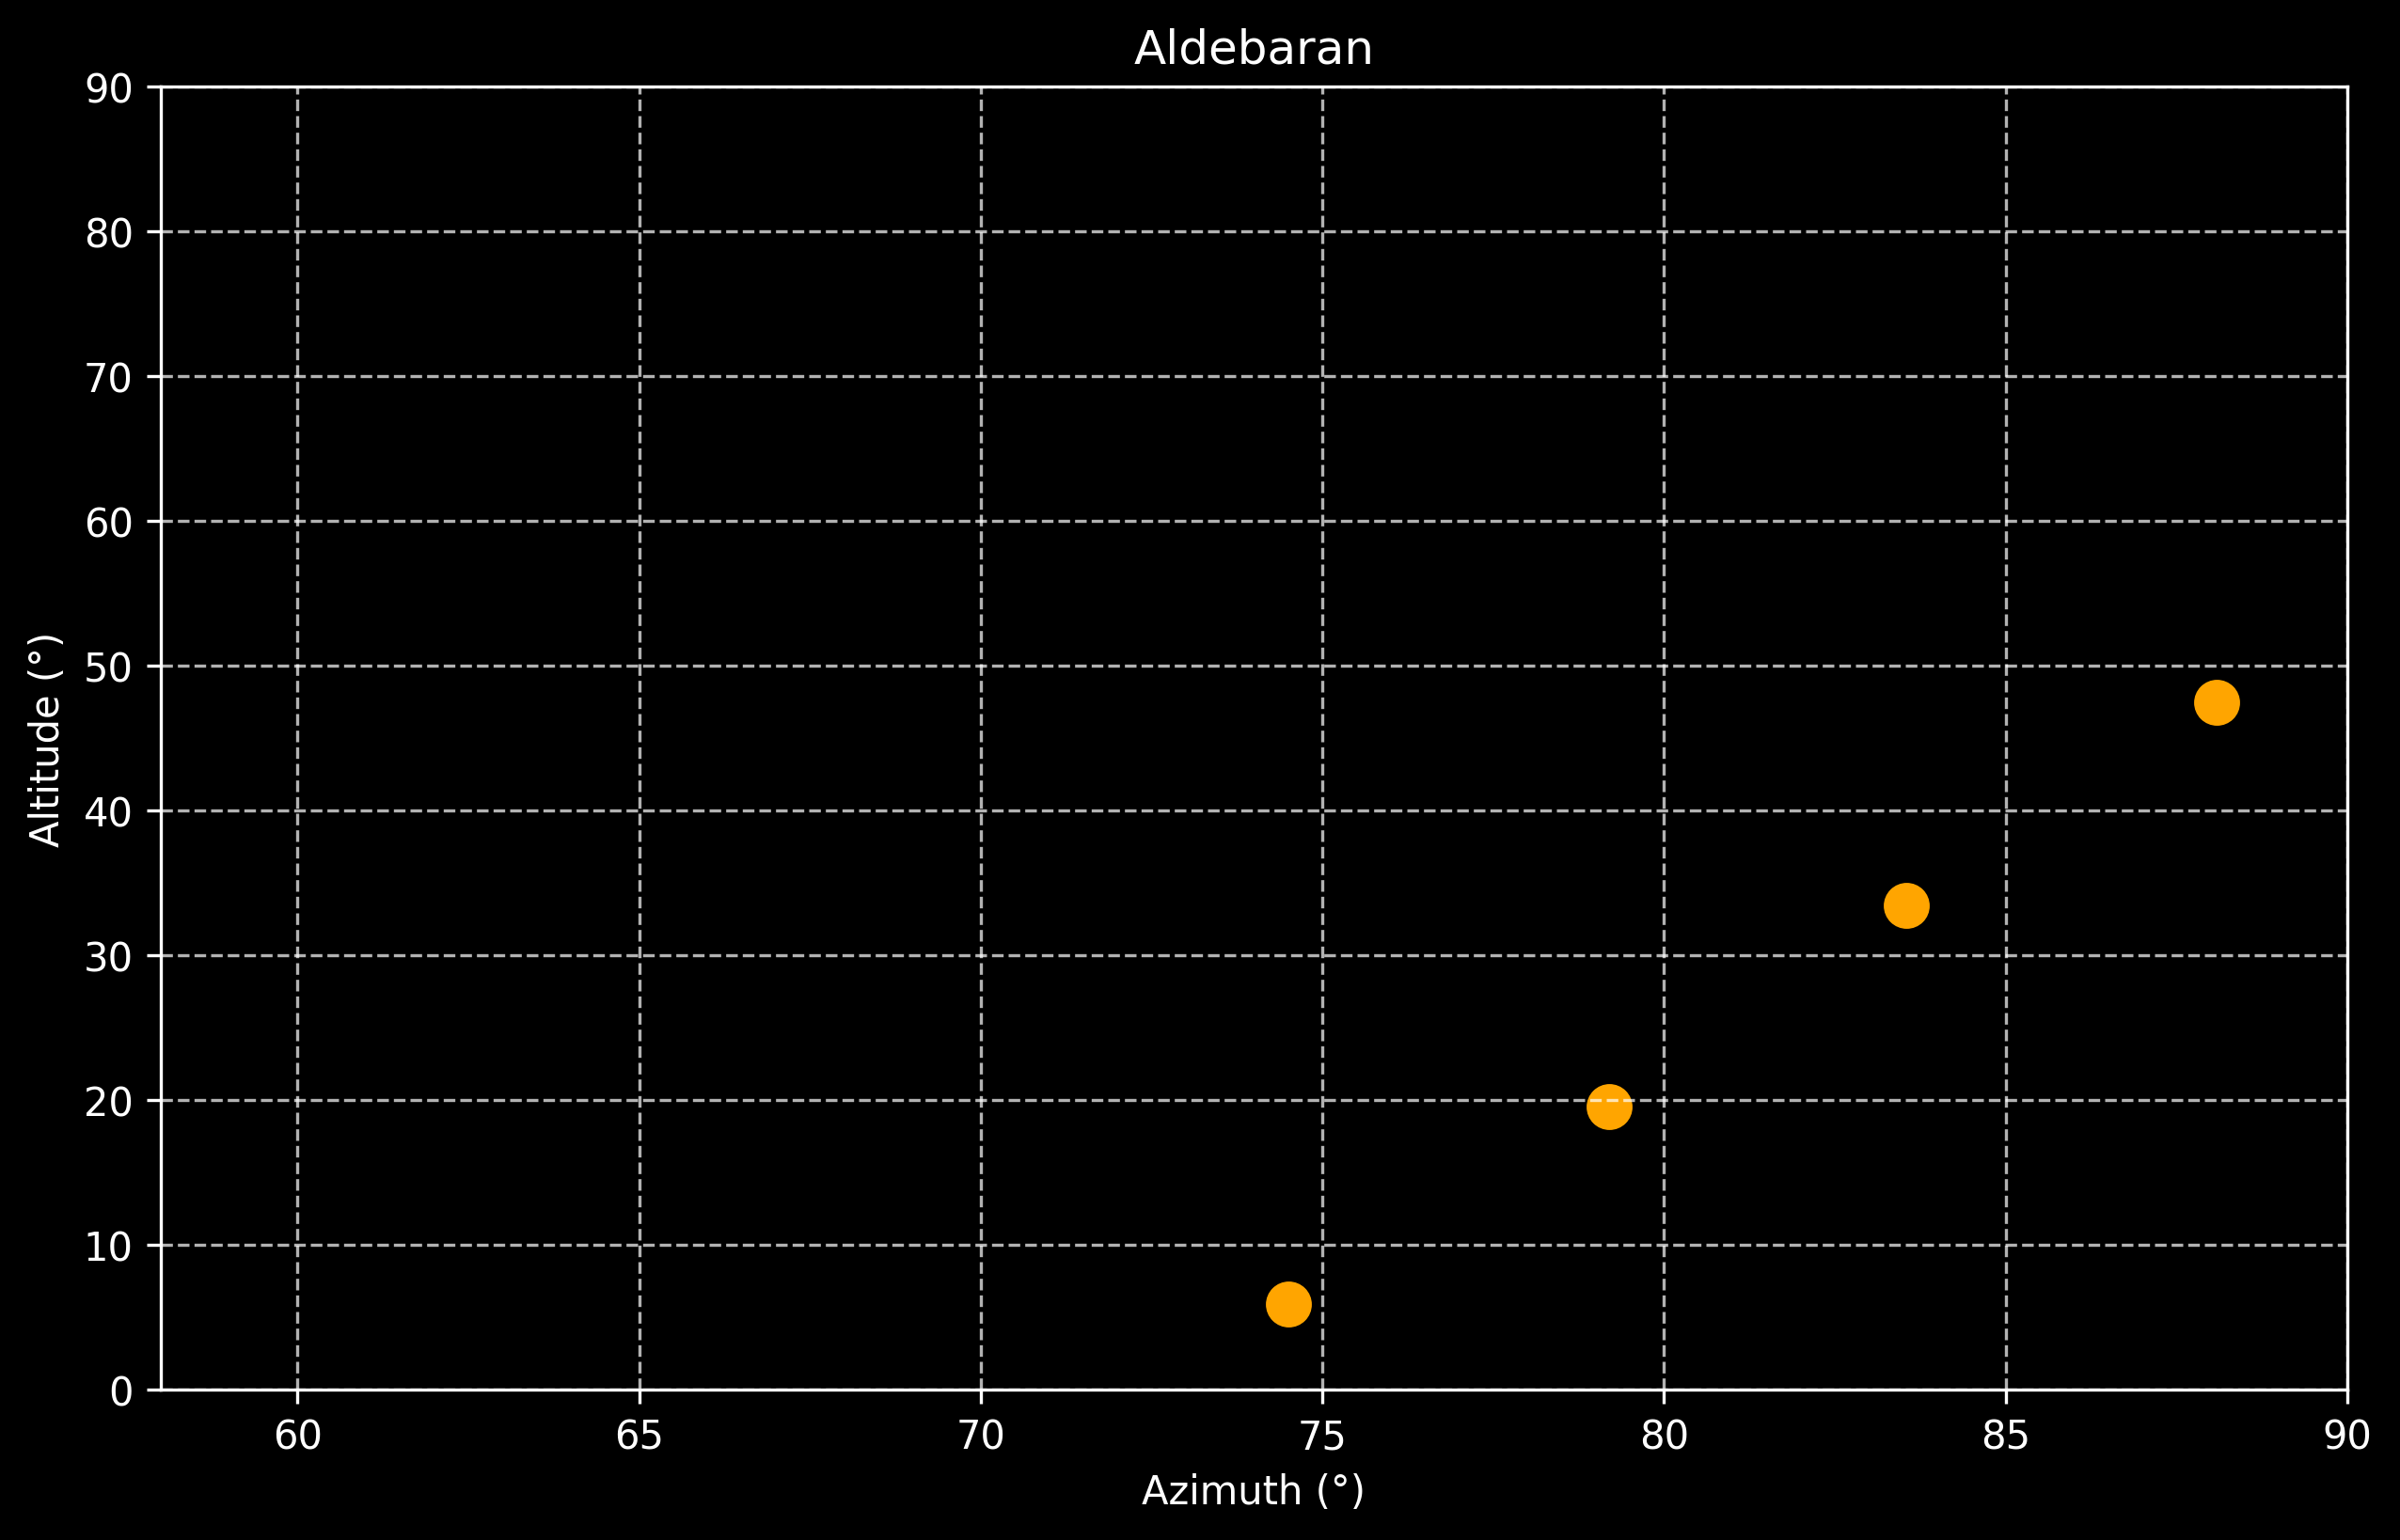

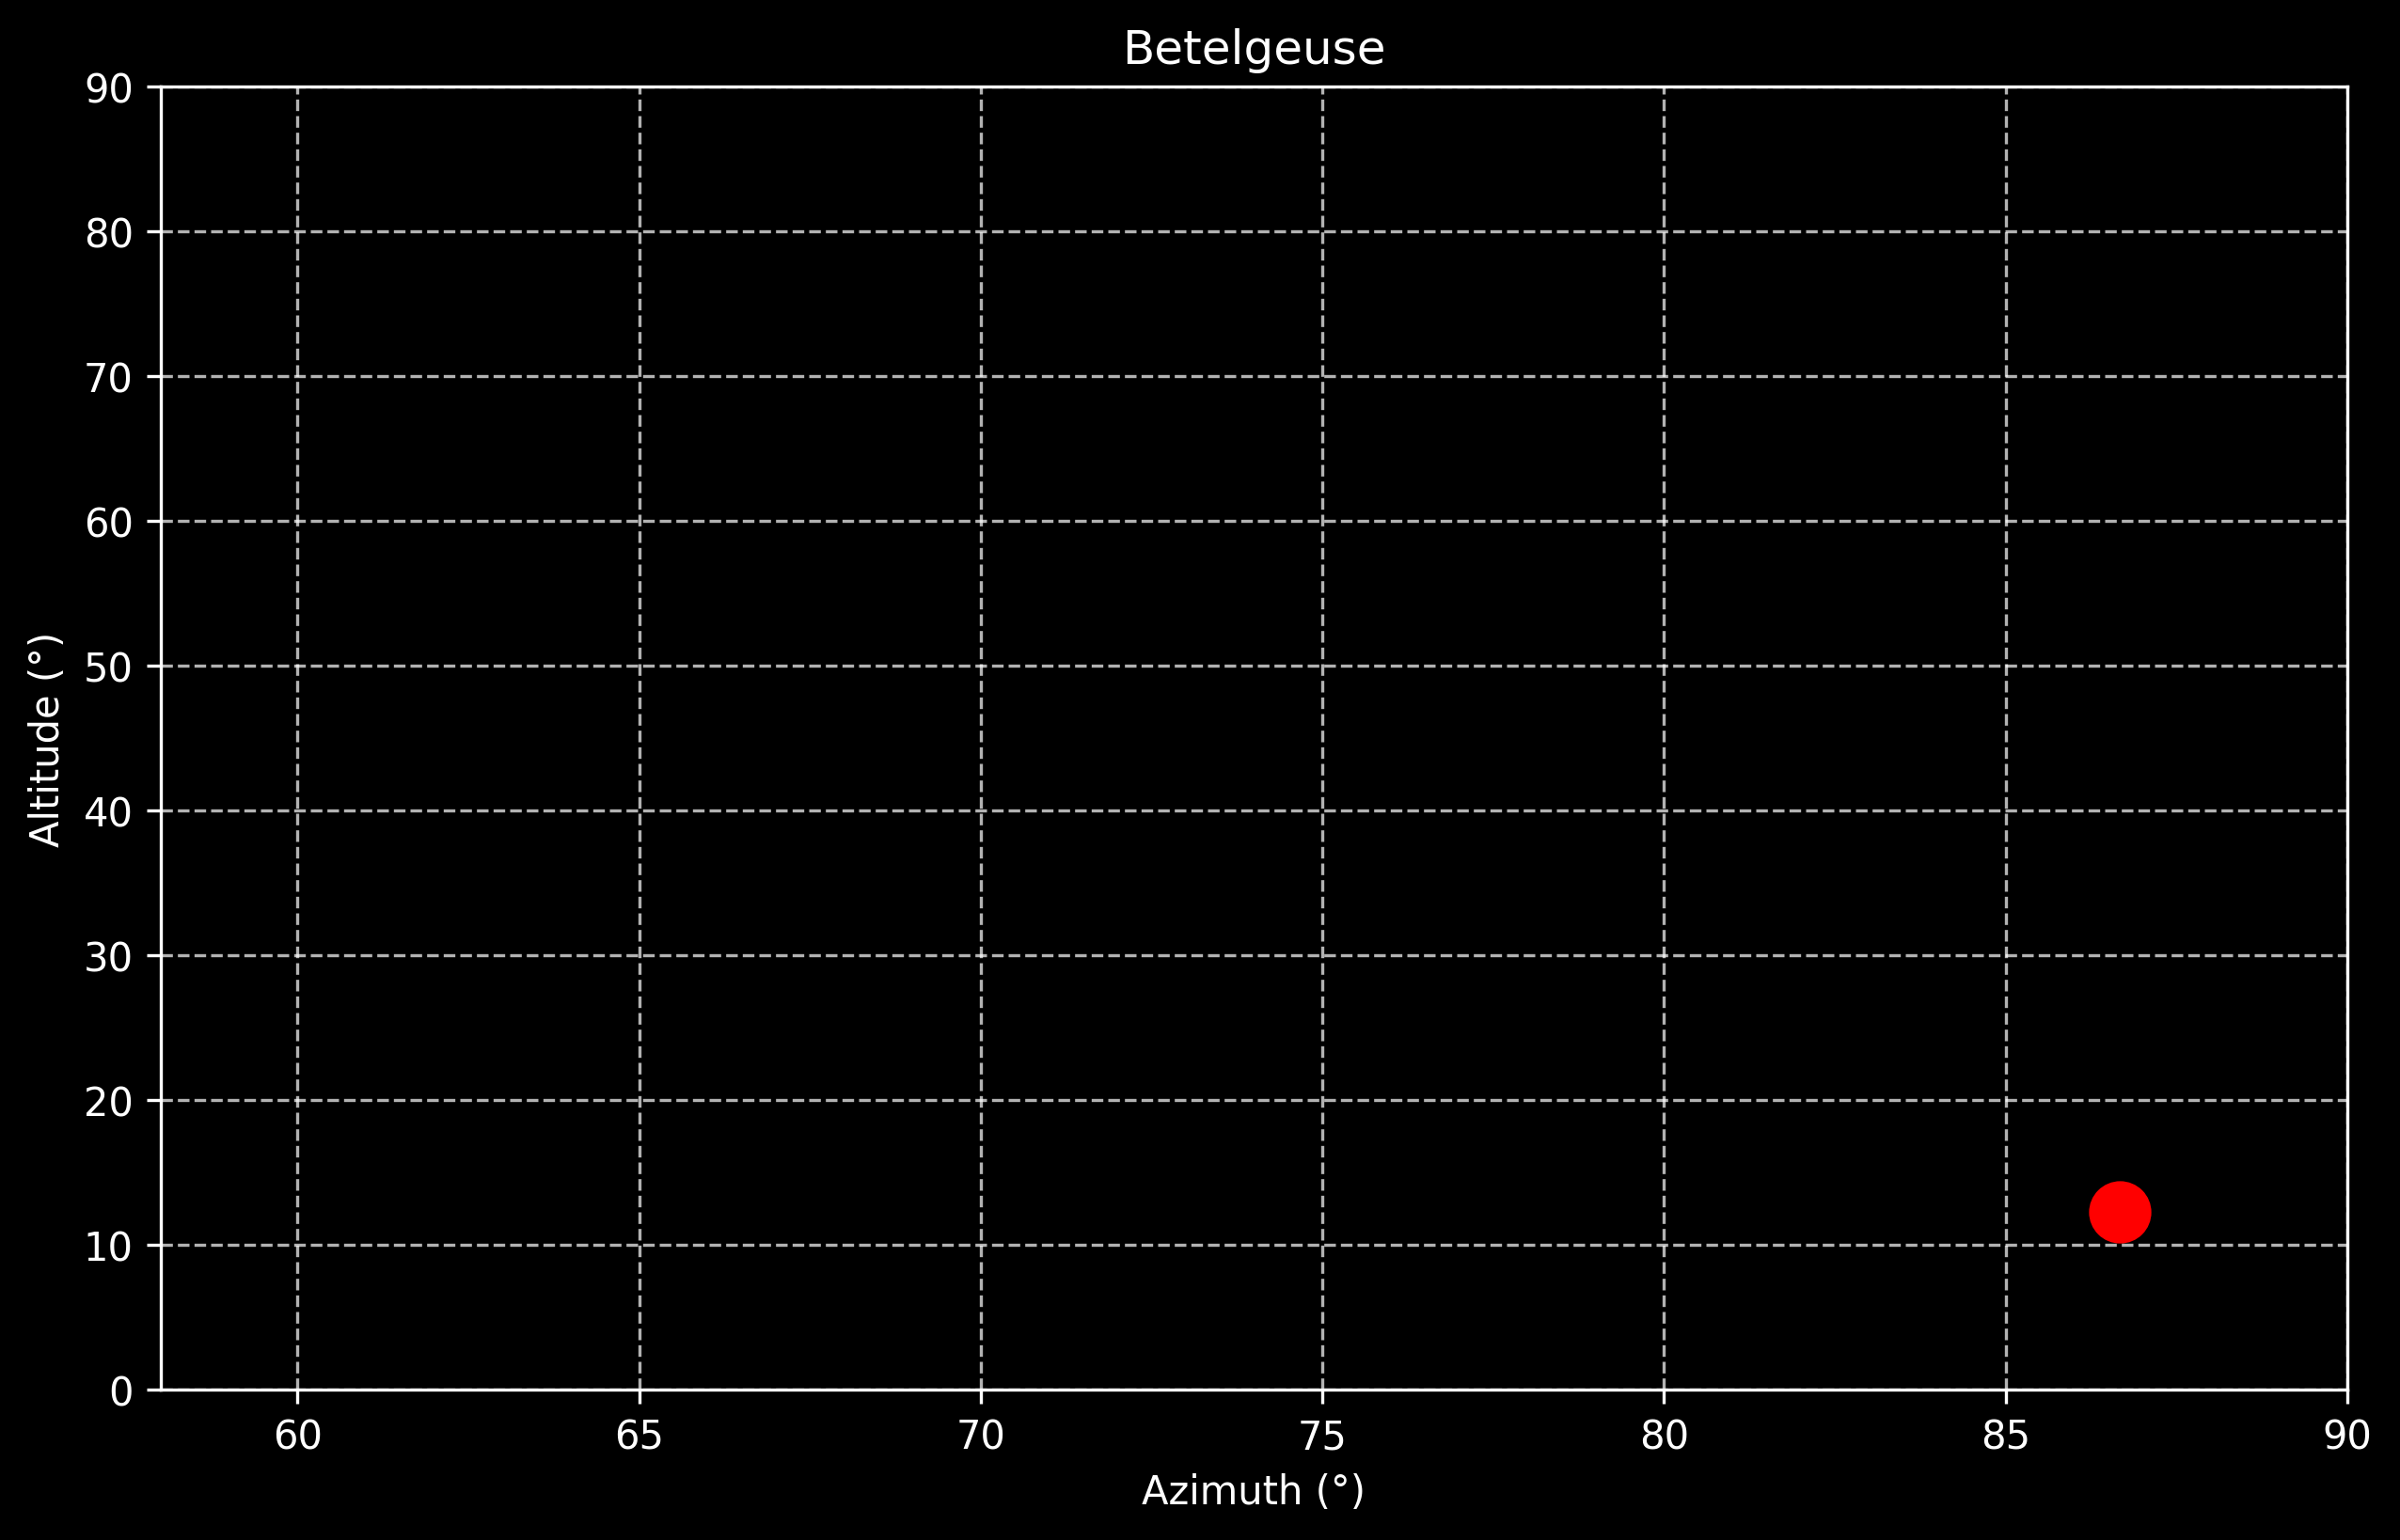

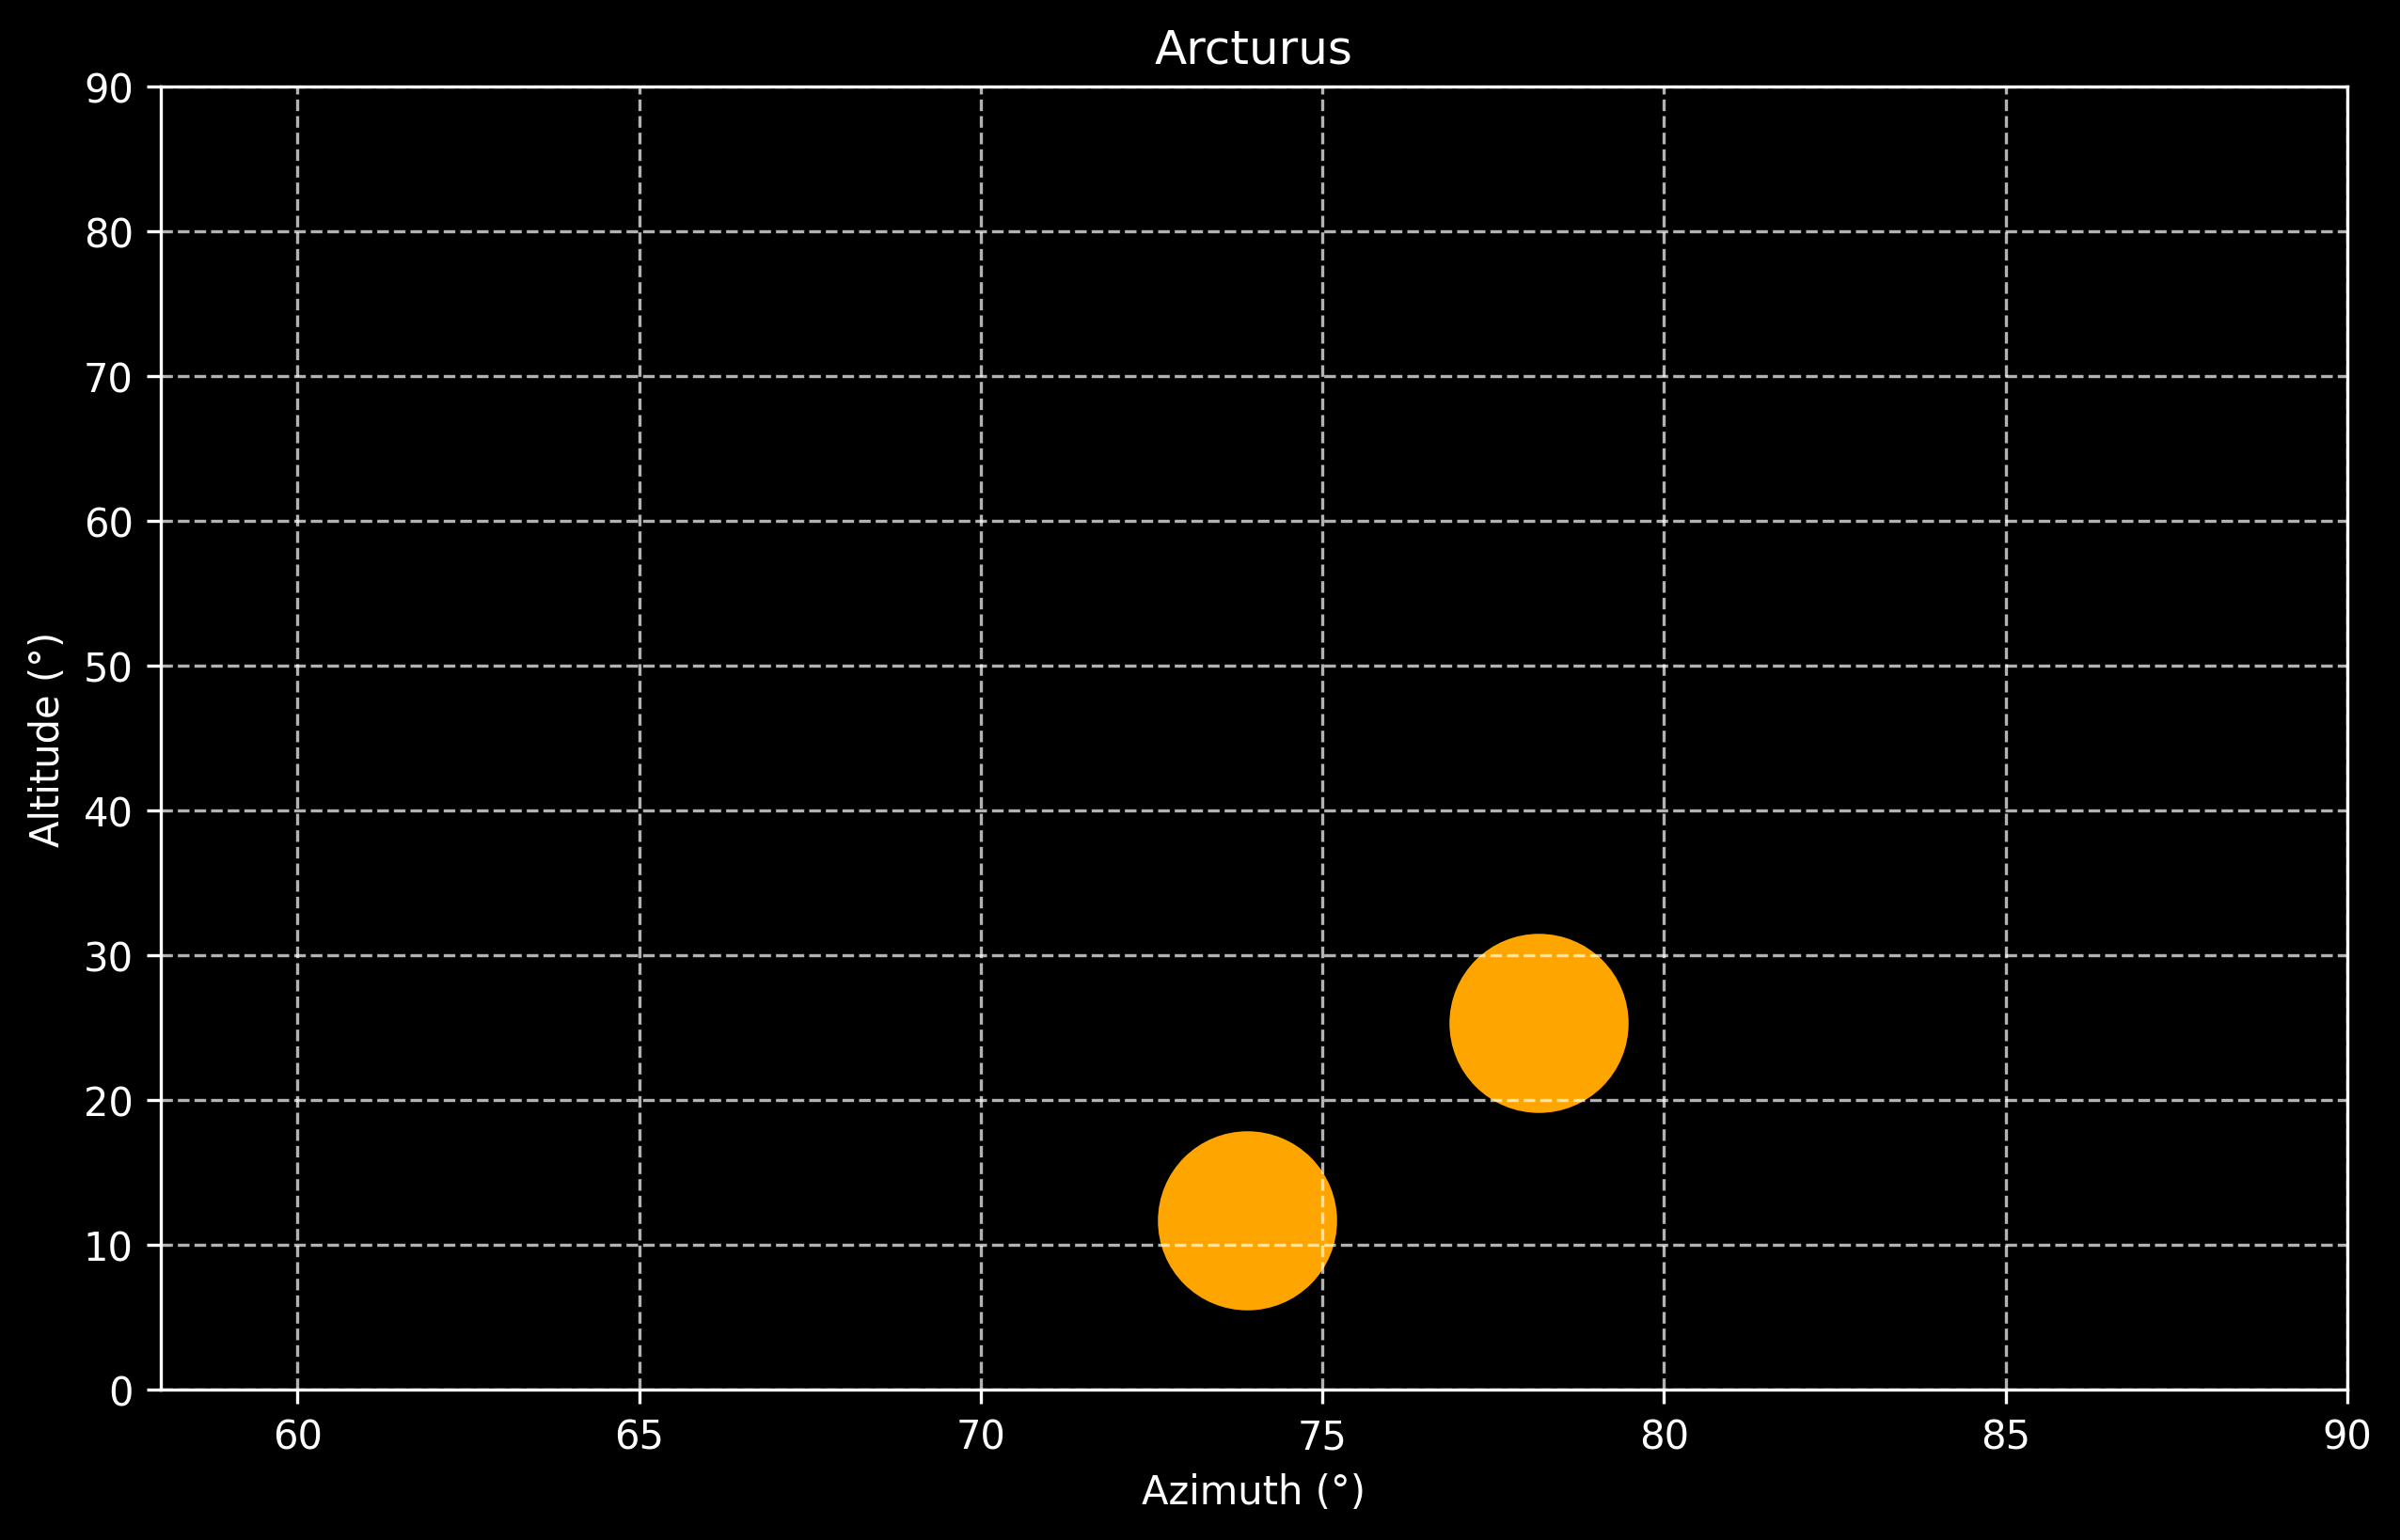

In [25]:
STAR_COLORS = {
    "Achernar": "cyan",
    "Acrux": "cyan",
    "Adhara": "lightskyblue",
    "Agena": "lightskyblue",
    "Albireo": "orange",
    "Aldebaran": "orange",
    "Algol": "orange",
    "Alhena": "white",
    "Alioth": "cyan",
    "Altair": "white",
    "Antares": "red",
    "Arcturus": "orange",
    "Bellatrix": "lightskyblue",
    "Betelgeuse": "red",
    "Canopus": "white",
    "Capella": "yellow",
    "Castor": "white",
    "Deneb": "white",
    "Fomalhaut": "white",
    "Hadar": "cyan",
    "Hamal": "orange",
    "Mizar": "white",
    "Polaris": "yellow",
    "Pollux": "orange",
    "Procyon": "yellow",
    "Rigel": "cyan",
    "Sirius": "white",
    "Spica": "cyan",
    "Vega": "lightskyblue",
}

def plot_star_positions(star_name, observations):
  azimuths = [obs['azimuth'] for obs in observations]
  altitudes = [obs['altitude'] for obs in observations]

  plt.style.use('dark_background')
  plt.figure(figsize=(10, 6), dpi=300)

  size = 100 / abs(observations[0]['magnitude'])

  color = STAR_COLORS[star_name] if star_name in STAR_COLORS else 'white'
  plt.scatter(azimuths, altitudes, color=color, s=size)

  plt.title(star_name.capitalize())
  plt.xlabel('Azimuth (°)')
  plt.ylabel('Altitude (°)')

  plt.xlim(BEARINGS[0], BEARINGS[1])
  plt.ylim(0, 90)

  plt.grid(True, linestyle='--', alpha=0.7)
  plt.show()

for name, observations in stars.items():
  if not observations:
    continue

  plot_star_positions(name, observations)

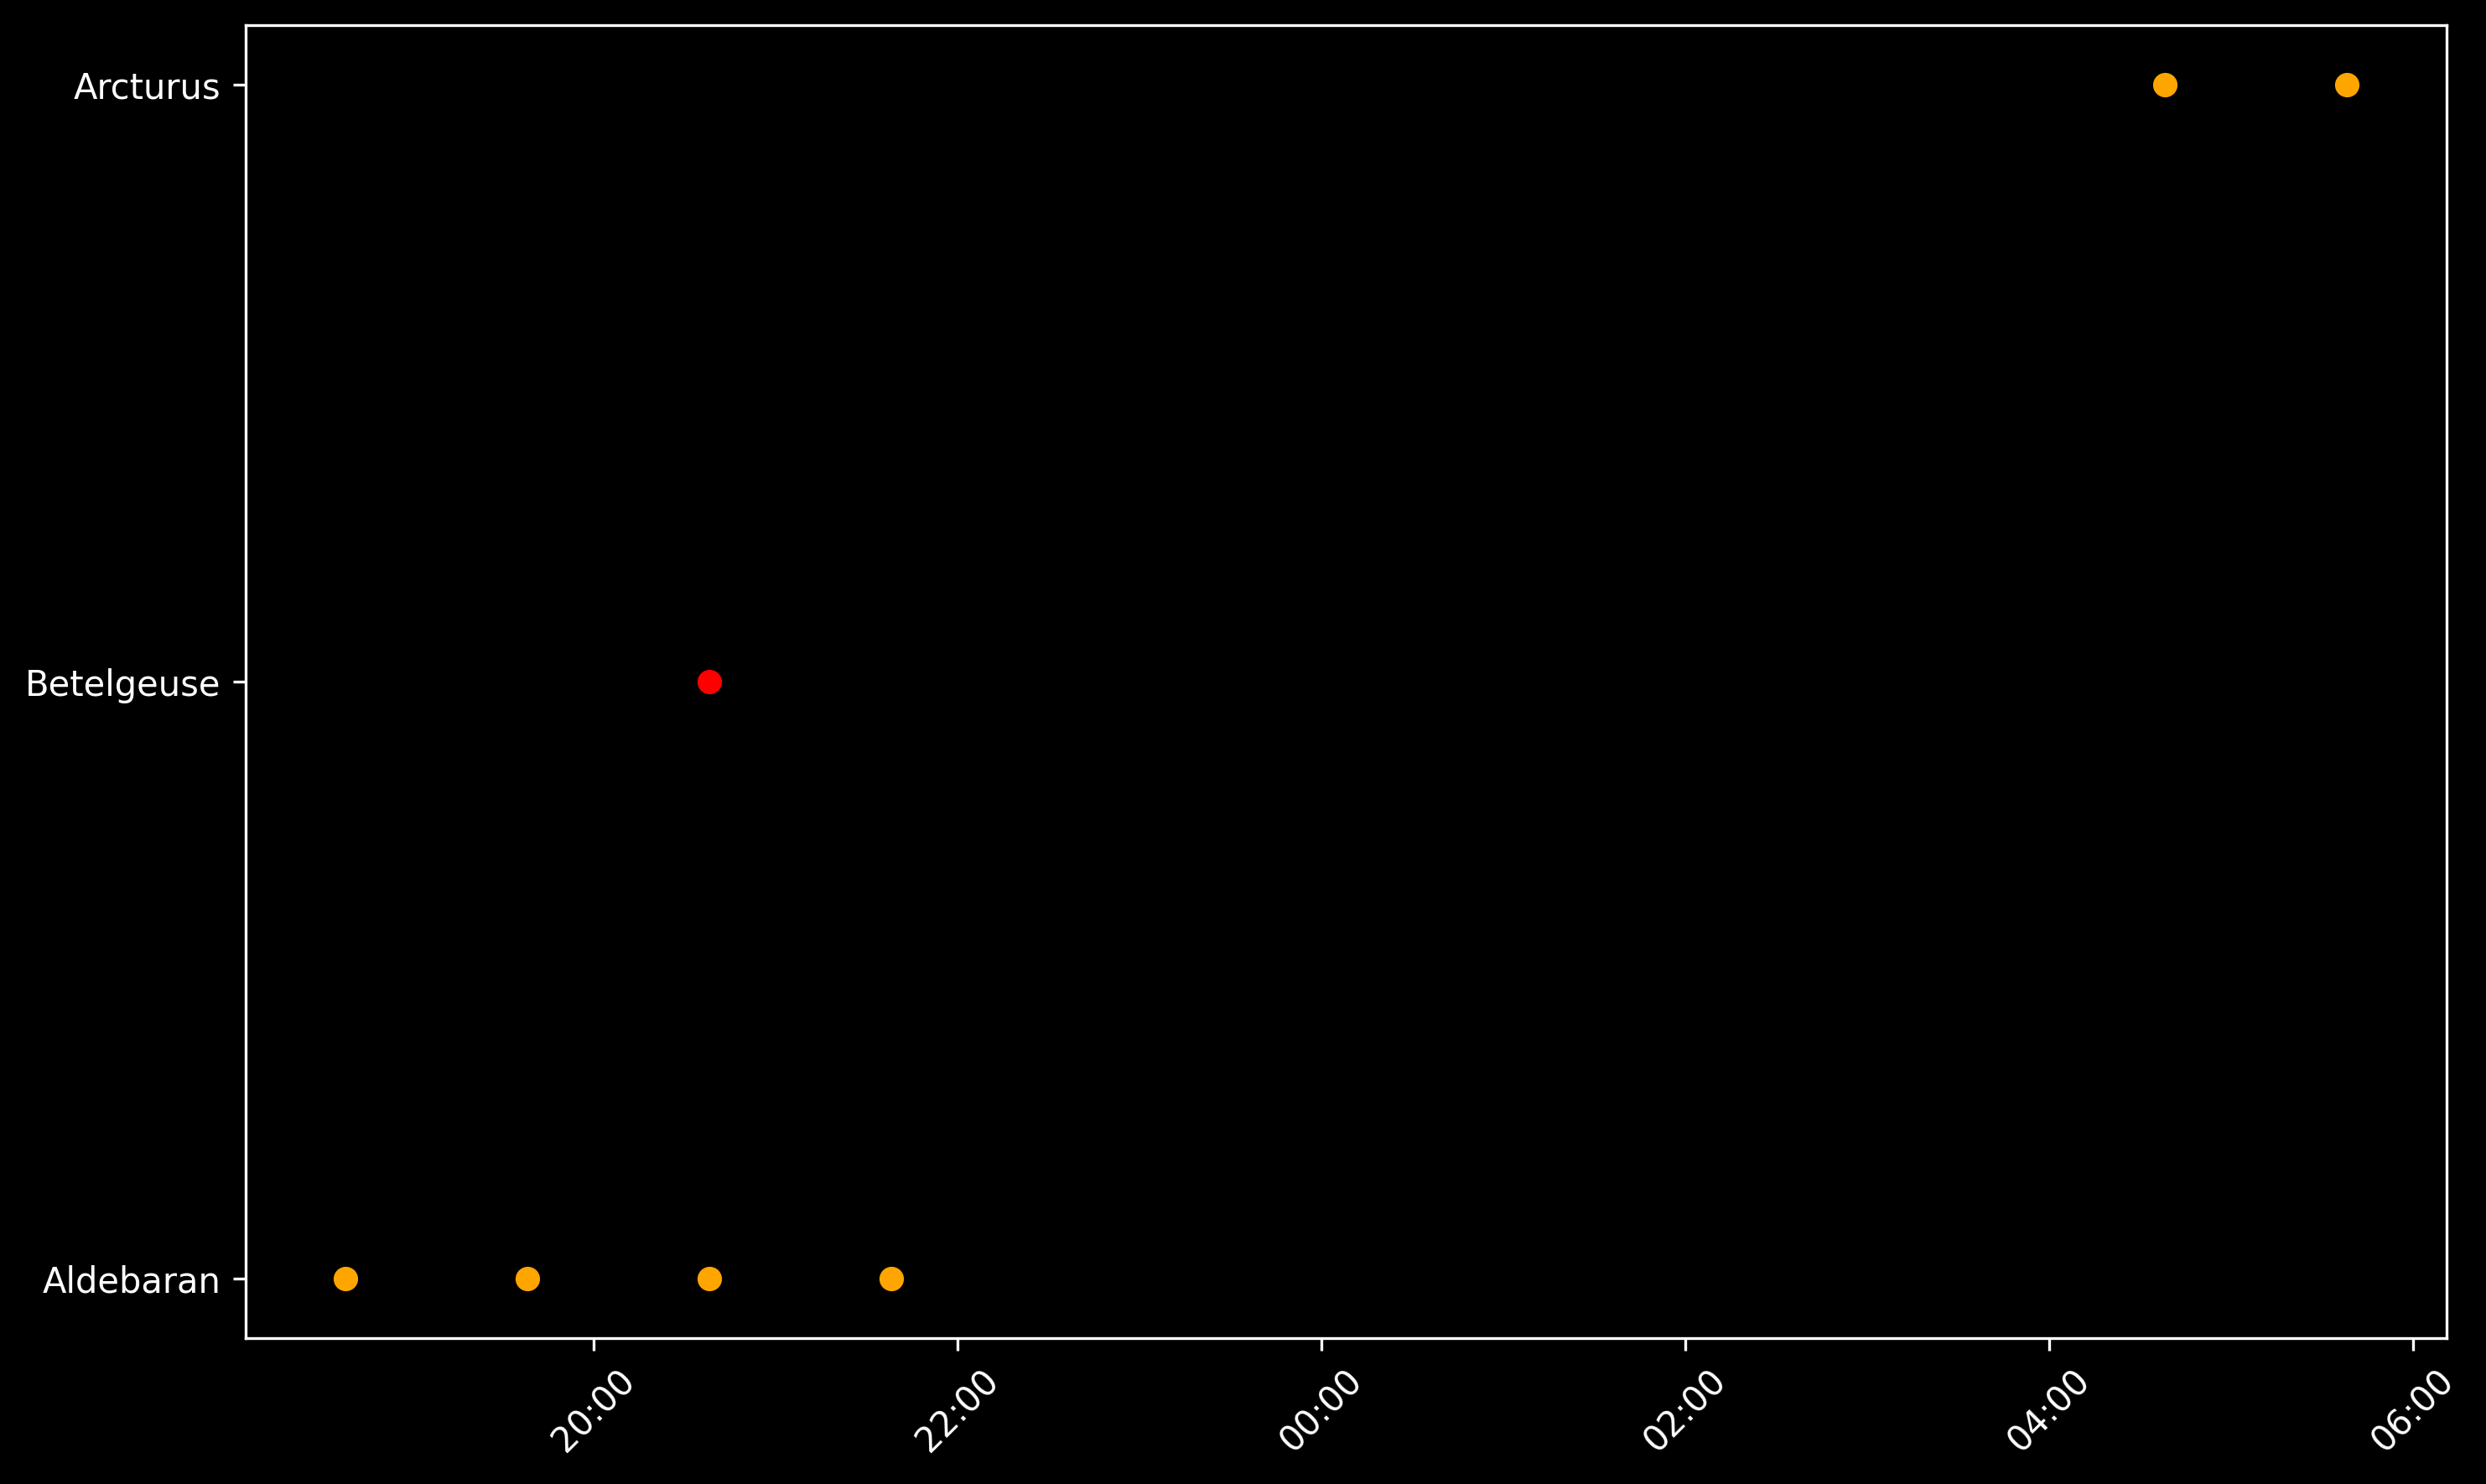

In [26]:
def plot_star_timeline(data):
  plt.style.use('dark_background')
  fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

  y_positions = {name: i for i, name in enumerate([p for p, e in data.items() if e])}

  for star_name, observations in stars.items():
      if not observations:
        continue

      times = [datetime.fromisoformat(event['event_time']) for event in observations]
      color = STAR_COLORS[star_name] if star_name in STAR_COLORS else 'white'

      ax.plot(times, [y_positions[star_name]] * len(times), 'o', c=color)

  ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
  plt.xticks(rotation=45)

  ax.set_yticks(list(y_positions.values()))
  ax.set_yticklabels(list(y_positions.keys()))

  plt.tight_layout()
  plt.show()

plot_star_timeline(stars)